In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
taxon = 9606

In [3]:
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)

C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\fmug_analysis\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)


In [4]:
ref_literature = datasets.reference_publications(taxon)

In [5]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [6]:
%%time
ml = ncbi.pubmed('main', ['pubmed_id', 'year'])

CPU times: total: 1.72 s
Wall time: 2.53 s


In [7]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
gene2pubmed = pd.merge(gene2pubmed, ml, how='left')
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 5.17 s
Wall time: 5.19 s


In [8]:
gene2pubmed_gene_count = gene2pubmed.groupby('pubmed_id').count()['gene_ncbi']

gene2pubmed_slice = gene2pubmed[gene2pubmed['pubmed_id'].isin(gene2pubmed_gene_count[gene2pubmed_gene_count == 1].index)]

In [9]:
np.mean(gene2pubmed_gene_count != 1)

0.3049324923515905

In [10]:
%%time
icite_stats = nih.icite(dataset='studies', columns=['pubmed_id', 'citation_count'])

CPU times: total: 1.34 s
Wall time: 1.47 s


In [11]:
%%time
gene2pubmed_slice = pd.merge(gene2pubmed_slice, icite_stats[icite_stats.columns[icite_stats.columns != 'year']],
                             how='left', on='pubmed_id')

CPU times: total: 6.47 s
Wall time: 6.47 s


In [12]:
%%time
np.random.seed(10)
year_array = range(1970, 2020)
corr_array = []
p_array = []
bootstrap_array = []
cite_median_df_array = []
for year in year_array:
    pub_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').count()['pubmed_id']
    cite_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').sum()['citation_count']
    cite_median = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').median()['citation_count']
    cite_mean = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').mean()['citation_count']

    gene2pubmed_dict = gene2pubmed[(~gene2pubmed['pubmed_id'].isin(large_pubs)) & 
            (gene2pubmed['year'] < year)].value_counts('gene_ncbi').to_dict()
    
    def gene2pubmed_gene_count(x):
        ret = gene2pubmed_dict.get(x)
        if ret:
            return ret
        else:
            return 0

    pub_count_previous = np.array([gene2pubmed_gene_count(x) for x in cite_count.index])
    rho, p = scipy.stats.spearmanr(pub_count_previous, cite_median)
    corr_array.append(rho)
    p_array.append(p)
    
    # bootstrapping estimates
    cite_median_df = pd.DataFrame(cite_median)
    cite_median_df['pub_count_previous'] = pub_count_previous
    cite_median_df['year'] = year
    cite_median_df_array.append(cite_median_df)
    
    bootstrap = []
    for n_b in range(1000):
        a = cite_median_df.sample(frac=1, replace=True)
        rho, p = scipy.stats.spearmanr(a['pub_count_previous'], a['citation_count'])
        bootstrap.append(rho)
        
    bootstrap_array.append(bootstrap)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
C:\Users\richa\anaconda3\envs\gene_env\l

CPU times: total: 33.3 s
Wall time: 33.3 s


In [18]:
pd.concat(cite_median_df_array).to_csv('../data/citation_count_vs_previous_pubs.csv')

In [13]:
tick_array = []
for mult in [1, 10, 100, 1000]:
    tick_array = tick_array + list(mult*np.array([1,2,3,4,5,6,7,8,9]))
tick_array = np.log10(np.array(tick_array))

In [14]:
tick_array

array([0.        , 0.30103   , 0.47712125, 0.60205999, 0.69897   ,
       0.77815125, 0.84509804, 0.90308999, 0.95424251, 1.        ,
       1.30103   , 1.47712125, 1.60205999, 1.69897   , 1.77815125,
       1.84509804, 1.90308999, 1.95424251, 2.        , 2.30103   ,
       2.47712125, 2.60205999, 2.69897   , 2.77815125, 2.84509804,
       2.90308999, 2.95424251, 3.        , 3.30103   , 3.47712125,
       3.60205999, 3.69897   , 3.77815125, 3.84509804, 3.90308999,
       3.95424251])

C:\Users\richa\AppData\Local\Temp\ipykernel_2220\4115822514.py:21: RuntimeWarning: divide by zero encountered in log10
  sns.regplot(x=np.log10(pub_count_previous), y=np.log10(cite_median), lowess=True,
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\core\function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\numpy\core\function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start
C:\Users\richa\AppData\Local\Temp\ipykernel_2220\4115822514.py:24: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(np.log10(pub_count_previous),
C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in l

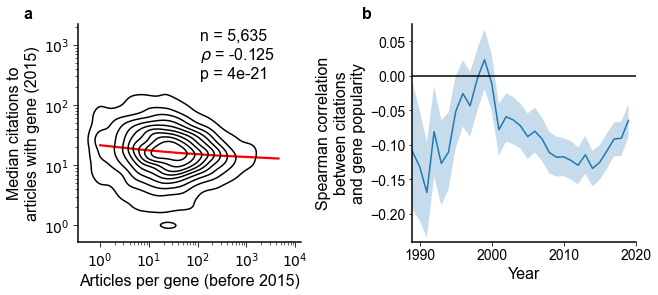

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), gridspec_kw={'wspace':0.5})

# panel a
ax = axes[0]
year = 2015
pub_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').count()['pubmed_id']
cite_count = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').sum()['citation_count']
cite_median = gene2pubmed_slice[gene2pubmed_slice['year'] == year].groupby('gene_ncbi').median()['citation_count']\

gene2pubmed_dict = gene2pubmed[(~gene2pubmed['pubmed_id'].isin(large_pubs)) & 
            (gene2pubmed['year'] < year)].value_counts('gene_ncbi').to_dict()
def gene2pubmed_gene_count(x):
    ret = gene2pubmed_dict.get(x)
    if ret:
        return ret
    else:
        return 0
        
pub_count_previous = np.array([gene2pubmed_gene_count(x) for x in cite_count.index])

sns.regplot(x=np.log10(pub_count_previous), y=np.log10(cite_median), lowess=True,
            scatter_kws={"color": "k", 's': 0, 'alpha':0.25, 'linewidth':0}, 
            line_kws={"color": "red"}, ax=ax)
sns.kdeplot(np.log10(pub_count_previous), 
            np.log10(cite_median), ax=ax, color='k')
#ax.axhline(gene2pubmed_slice[gene2pubmed_slice['year'] == year]['citation_count'].median()+1)
#ax.set_xscale('log')
#ax.set_yscale('log')

ax.tick_params(labelsize=14)
ax.set_ylabel('Median citations to\narticles with gene (' + str(year) + ')', fontsize=16)
ax.set_xlabel('Articles per gene (before ' + str(year) + ')', fontsize=16)
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

rho, p = scipy.stats.spearmanr(pub_count_previous, cite_median)
n_genes = len(cite_median)

ax.text(s='n = ' + '{:,}'.format(n_genes) + '\n' + r'$\rho$ = {:.3f}'.format(rho) + '\np = ' + '{:.0e}'.format(p), 
        x=0.55, y=0.75, fontsize=16, backgroundcolor='w', bbox={'alpha':0.9, 'color':'w'}, transform=ax.transAxes)
ax.xaxis.set_minor_locator(mpl.ticker.FixedLocator(tick_array))
ax.yaxis.set_minor_locator(mpl.ticker.FixedLocator(tick_array))
ax.tick_params(axis='both', length=5, which='major')
ax.tick_params(axis='both', length=3, which='minor')
ax.xaxis.set_ticklabels(['',r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])
ax.yaxis.set_ticklabels(['',r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$', r'$10^4$'])

# panel b
ax = axes[1]
ax.plot(year_array, corr_array, linewidth=1.5)
ax.fill_between(x=year_array, 
                y1=np.percentile(bootstrap_array, 2.5, axis=1), 
                y2=np.percentile(bootstrap_array, 97.5, axis=1), alpha=0.25)
ax.axhline(0.0, linewidth=1.5, color='k')

ax.tick_params(labelsize=14)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Spearman correlation\nbetween citations\nand gene popularity', fontsize=16, rotation=90)
ax.set_xlim([1989,2020])
ax.set_yticks(np.arange(-0.5,0.5,0.05))
ax.set_ylim([-0.24,0.075])
[ax.spines[i].set_linewidth(1.5) for i in ax.spines]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.text(s='a', x=0.05, y=0.9, fontsize=16, weight='bold')
fig.text(s='b', x=0.52, y=0.9, fontsize=16, weight='bold')

plt.savefig('../img/bulk_citation_fig.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/bulk_citation_fig.pdf', bbox_inches='tight')

export.image('general', p='figures/figure_1_.pdf', date=True)
export.raster_image('general', p='figures/figure_1_.png', date=True, dpi=600)

Are there just more low-citation publications for highly-studied genes?

In [179]:
output_df_array = []

for year in range(1990, 2021):

    gene2pubmed_dict = gene2pubmed[(~gene2pubmed['pubmed_id'].isin(large_pubs)) & 
                (gene2pubmed['year'] < year)].value_counts('gene_ncbi').to_dict()

    def gene2pubmed_gene_count(x):
        ret = gene2pubmed_dict.get(x)
        if ret:
            return ret
        else:
            return 0

    year_slice = gene2pubmed_slice[gene2pubmed_slice['year'] == year].copy()
    year_slice['pub_count_previous'] = year_slice['gene_ncbi'].apply(lambda x: gene2pubmed_gene_count(x))
    year_slice['citation_pct'] = year_slice['citation_count'].rank(pct=True, method='min')
    year_slice['highly_cited'] = year_slice['citation_pct'] >= 0.95
    year_slice['lowly_cited'] = year_slice['citation_pct'] <= 0.05
    year_slice['exists'] = True

    a = np.array([gene2pubmed_gene_count(x) for x in ref_genes])

    output_df = pd.DataFrame(year_slice[year_slice['pub_count_previous'] <= np.percentile(a, 5)].sum()[['highly_cited', 'lowly_cited', 'exists']]).T
    output_df['gene_type'] = 'low'
    output_df['year'] = year
    output_df_array.append(output_df)

    output_df = pd.DataFrame(year_slice[year_slice['pub_count_previous'] >= np.percentile(a, 95)].sum()[['highly_cited', 'lowly_cited', 'exists']]).T
    output_df['gene_type'] = 'high'
    output_df['year'] = year
    output_df_array.append(output_df)

In [180]:
result_df = pd.concat(output_df_array)

In [181]:
result_df['p_highly_cited'] = result_df['highly_cited']/result_df['exists']
result_df['se_highly_cited'] = np.sqrt(result_df['p_highly_cited']*(1-result_df['p_highly_cited'])/result_df['exists'])
result_df['p_lowly_cited'] = result_df['lowly_cited']/result_df['exists']
result_df['se_lowly_cited'] = np.sqrt(result_df['p_lowly_cited']*(1-result_df['p_lowly_cited'])/result_df['exists'])

meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


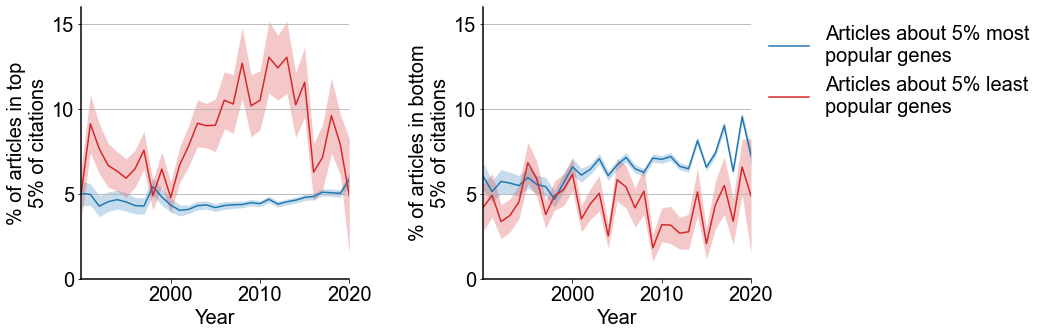

In [189]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,5), gridspec_kw={'wspace':0.5})

result_df_slice = result_df[result_df['gene_type'] == 'high']
axes[0].plot(result_df_slice['year'], 100*result_df_slice['p_highly_cited'], color=sns.color_palette()[0])
axes[0].fill_between(x=result_df_slice['year'], 
                     y1=100*(result_df_slice['p_highly_cited']-result_df_slice['se_highly_cited']), 
                     y2=100*(result_df_slice['p_highly_cited']+result_df_slice['se_highly_cited']),
                     color=sns.color_palette()[0], linewidth=0, alpha=0.25)

result_df_slice = result_df[result_df['gene_type'] == 'low']
axes[0].plot(result_df_slice['year'], 100*result_df_slice['p_highly_cited'], color=sns.color_palette()[3])
axes[0].fill_between(x=result_df_slice['year'], 
                     y1=100*(result_df_slice['p_highly_cited']-result_df_slice['se_highly_cited']), 
                     y2=100*(result_df_slice['p_highly_cited']+result_df_slice['se_highly_cited']),
                     color=sns.color_palette()[3], linewidth=0, alpha=0.25)

result_df_slice = result_df[result_df['gene_type'] == 'high']
axes[1].plot(result_df_slice['year'], 100*result_df_slice['p_lowly_cited'], color=sns.color_palette()[0],
             label='Articles about 5% most\npopular genes')
axes[1].fill_between(x=result_df_slice['year'], 
                     y1=100*(result_df_slice['p_lowly_cited']-result_df_slice['se_lowly_cited']), 
                     y2=100*(result_df_slice['p_lowly_cited']+result_df_slice['se_lowly_cited']),
                     color=sns.color_palette()[0], linewidth=0, alpha=0.25)

result_df_slice = result_df[result_df['gene_type'] == 'low']
axes[1].plot(result_df_slice['year'], 100*result_df_slice['p_lowly_cited'], color=sns.color_palette()[3], 
             label='Articles about 5% least\npopular genes')
axes[1].fill_between(x=result_df_slice['year'], 
                     y1=100*(result_df_slice['p_lowly_cited']-result_df_slice['se_lowly_cited']), 
                     y2=100*(result_df_slice['p_lowly_cited']+result_df_slice['se_lowly_cited']),
                     color=sns.color_palette()[3], linewidth=0, alpha=0.25)

for ax in axes:
    ax.tick_params(labelsize=20)
    ax.set_xlabel('Year', fontsize=20)
    #ax.set_ylabel('Spearman correlation\nbetween citations\nand gene popularity', fontsize=16, rotation=90)
    ax.set_xlim([1990,2020])
    ax.set_xticks([2000,2010,2020])
    #ax.set_yticks(np.arange(-0.5,0.5,0.05))
    ax.set_ylim([0,16])
    [ax.spines[i].set_linewidth(1.5) for i in ax.spines]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y')
    
axes[0].set_ylabel('% of articles in top\n5% of citations', fontsize=20)
axes[1].set_ylabel('% of articles in bottom\n5% of citations', fontsize=20)
axes[1].legend(fontsize=20, frameon=False, bbox_to_anchor=(1,1), loc='upper left')

plt.savefig('../img/highly_cited_vs_lowly_cited.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/highly_cited_vs_lowly_cited.pdf', bbox_inches='tight')

export.image('general', p='figures/highly_cited_vs_lowly_cited_.pdf', date=True)
export.raster_image('general', p='figures/highly_cited_vs_lowly_cited_.png', date=True, dpi=600)